# Model Reconstruction
Look at the internal represetations of trained models

## Import helper functions from author
Source: https://github.com/XifengGuo/CapsNet-Keras 

In [1]:
# System paths
import sys
sys.path.append('./CapNet_core')

import numpy as np
from keras import layers, models, optimizers
from keras import backend as K
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from PIL import Image

/Users/anthony/anaconda3/envs/ImgCV/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Their own packages
from utils import combine_images
from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask

#### Functions needed

In [3]:
def CapsNet(input_shape, n_class, routings):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 3d, [width, height, channels]
    :param n_class: number of classes
    :param routings: number of routing iterations
    :return: Two Keras Models, the first one used for training, and the second one for evaluation.
            `eval_model` can also be used for training.
    """
    x = layers.Input(shape=input_shape)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
    primarycaps = PrimaryCap(conv1, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
                             name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='capsnet')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
    masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction

    # Shared Decoder model in training and prediction
    decoder = models.Sequential(name='decoder')
    decoder.add(layers.Dense(512, activation='relu', input_dim=16*n_class))
    decoder.add(layers.Dense(1024, activation='relu'))
    decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
    decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

    # Models for training and evaluation (prediction)
    train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
    eval_model = models.Model(x, [out_caps, decoder(masked)])

    # manipulate model
    noise = layers.Input(shape=(n_class, 16))
    noised_digitcaps = layers.Add()([digitcaps, noise])
    masked_noised_y = Mask()([noised_digitcaps, y])
    manipulate_model = models.Model([x, y, noise], decoder(masked_noised_y))
    return train_model, eval_model, manipulate_model

In [4]:
def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))


# NOTE (anthony): modified
def train(model, data, args):
    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    :param args: arguments
    :return: The trained model
    """
    # unpacking the data
    (x_train, y_train), (x_test, y_test) = data

    # callbacks
    #log = callbacks.CSVLogger(args.save_dir + '/log.csv')
    #tb = callbacks.TensorBoard(log_dir=args.save_dir + '/tensorboard-logs',
    #                           batch_size=args.batch_size, histogram_freq=int(args.debug))
    #checkpoint = callbacks.ModelCheckpoint(args.save_dir + '/weights-{epoch:02d}.h5', monitor='val_capsnet_acc',
    #                                       save_best_only=True, save_weights_only=True, verbose=1)
    #lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: args.lr * (args.lr_decay ** epoch))

    # compile the model
    model.compile(optimizer=optimizers.Adam(lr=args['lr']),
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., args['lam_recon']],
                  metrics={'capsnet': 'accuracy'})

    """
    # Training without data augmentation:
    model.fit([x_train, y_train], [y_train, x_train], batch_size=args.batch_size, epochs=args.epochs,
              validation_data=[[x_test, y_test], [y_test, x_test]], callbacks=[log, tb, checkpoint, lr_decay])
    """

    # Begin: Training with data augmentation ---------------------------------------------------------------------#
    def train_generator(x, y, batch_size, shift_fraction=0.):
        train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
                                           height_shift_range=shift_fraction)  # shift up to 2 pixel for MNIST
        generator = train_datagen.flow(x, y, batch_size=batch_size)
        while 1:
            x_batch, y_batch = generator.next()
            yield ([x_batch, y_batch], [y_batch, x_batch])

    # Training with data augmentation. If shift_fraction=0., also no augmentation.
    model.fit_generator(generator=train_generator(x_train, y_train, args['batch_size'], args['shift_fraction']),
                        steps_per_epoch=int(y_train.shape[0] / args['batch_size']),
                        epochs=args['epochs'],
                        validation_data=[[x_test, y_test], [y_test, x_test]]
                       )
    #                    callbacks=[log, tb, checkpoint, lr_decay])
    # End: Training with data augmentation -----------------------------------------------------------------------#

    #model.save_weights(args.save_dir + '/trained_model.h5')
    #print('Trained model saved to \'%s/trained_model.h5\'' % args.save_dir)

    #from utils import plot_log
    #plot_log(args.save_dir + '/log.csv', show=True)

    return model


def test(model, data, args):
    x_test, y_test = data
    y_pred, x_recon = model.predict(x_test, batch_size=100)
    print('-'*30 + 'Begin: test' + '-'*30)
    print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1))/y_test.shape[0])

    img = combine_images(np.concatenate([x_test[:50],x_recon[:50]]))
    image = img * 255
    Image.fromarray(image.astype(np.uint8)).save(args.save_dir + "/real_and_recon.png")
    print()
    print('Reconstructed images are saved to %s/real_and_recon.png' % args.save_dir)
    print('-' * 30 + 'End: test' + '-' * 30)
    plt.imshow(plt.imread(args.save_dir + "/real_and_recon.png"))
    plt.show()

In [5]:
def manipulate_latent(model, data, args):
    print('-'*30 + 'Begin: manipulate' + '-'*30)
    x_test, y_test = data
    index = np.argmax(y_test, 1) == args['digit']
    number = np.random.randint(low=0, high=sum(index) - 1)
    x, y = x_test[index][number], y_test[index][number]
    x, y = np.expand_dims(x, 0), np.expand_dims(y, 0)
    noise = np.zeros([1, 10, 16])
    x_recons = []
    for dim in range(16):
        for r in [-0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25]:
            tmp = np.copy(noise)
            tmp[:,:,dim] = r
            x_recon = model.predict([x, y, tmp])
            x_recons.append(x_recon)

    x_recons = np.concatenate(x_recons)

    img = combine_images(x_recons, height=16)
    image = img*255
    #Image.fromarray(image.astype(np.uint8)).save(args.save_dir + '/manipulate-%d.png' % args.digit)
    #print('manipulated result saved to %s/manipulate-%d.png' % (args.save_dir, args.digit))
    #print('-' * 30 + 'End: manipulate' + '-' * 30)
    return image


def load_mnist():
    # the data, shuffled and split between train and test sets
    from keras.datasets import mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
    x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.
    y_train = to_categorical(y_train.astype('float32'))
    y_test = to_categorical(y_test.astype('float32'))
    return (x_train, y_train), (x_test, y_test)

## Get data and weights
### Get Data

In [59]:
# Path to the data
#DATA_PATH = '/Users/anthony/Documents/Comp551_Projects/CapNET/data/fashion_mnist_Data.npz'
#DATA_PATH = '/Users/anthony/Documents/Comp551_Projects/CapNET/data/mnistData.npz'
DATA_PATH = '/Users/anthony/Documents/Comp551_Projects/CapNET/data/noisy_mnist_data_0-38.npz'

# Load and unpack data
dataDict = np.load(DATA_PATH)
X_train = dataDict['X_train']
y_train = dataDict['y_train']
X_test = dataDict['X_test']
y_test = dataDict['y_test']

# Expand each dimension
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)    

print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_test))
print(np.shape(y_test))

(60000, 28, 28, 1)
(60000, 10)
(10000, 28, 28, 1)
(10000, 10)


#### Check scaling

In [61]:
SCALE = False

print("Original Feature range: [%f - %f]" % (np.min(X_train),np.max(X_train)))

if SCALE:
  X_train = X_train / np.max(X_train)
  X_test = X_test / np.max(X_test)
  
  print("Scale Feature Ranges:")
  print("[%f - %f]" % (np.min(X_train),np.max(X_train)))
  print("[%f - %f]" % (np.min(X_test),np.max(X_test)))

Original Feature range: [0.000000 - 1.000000]


#### Path to the weights for the manipulatable model

In [76]:
#MANIP_WEIGHTS = '/Users/anthony/Documents/Comp551_Projects/CapNET/trained_models/fashion_20Epochs/fashion_20_epochs_manipulate-model_weights.h5'     
#MANIP_WEIGHTS='/Users/anthony/Documents/Comp551_Projects/CapNET/trained_models/mnist_5Epochs/mnist_5Epochs_manipulate-modelWeights.h5'
#MANIP_WEIGHTS='/Users/anthony/Documents/Comp551_Projects/CapNET/trained_models/noisy_mnist/noisy_0_38_model_manipulate-model_weights.h5'


#MANIP_WEIGHTS='/Users/anthony/Documents/Comp551_Projects/CapNET/trained_CapNET/mnist_50_manipulate-model_weights.h5'
#MANIP_WEIGHTS='/Users/anthony/Documents/Comp551_Projects/CapNET/trained_CapNET/mnist_noisy_70_manipulate-model_weights.h5'
#MANIP_WEIGHTS='/Users/anthony/Documents/Comp551_Projects/CapNET/trained_CapNET/fashion_70_manipulate-model_weights.h5'


## Define model


In [63]:
import os
import argparse
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks

In [64]:
args = {
    "epochs":20,
    "batch_size": 100,
    "lr":0.001,
    "lr_decay":0.9,
    'lam_recon': 0.392,
    "r": 3,
    "shift_fraction": 0.1,
    "digit": 5,
    "w": None
}

#### Define and compile the model

In [65]:
model, eval_model, manipulate_model = CapsNet(input_shape=X_train.shape[1:],
                                              n_class=len(np.unique(np.argmax(y_train, 1))),
                                              routings=args['r'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 20, 20, 256)  20992       input_10[0][0]                   
__________________________________________________________________________________________________
primarycap_conv2d (Conv2D)      (None, 6, 6, 256)    5308672     conv1[0][0]                      
__________________________________________________________________________________________________
primarycap_reshape (Reshape)    (None, 1152, 8)      0           primarycap_conv2d[0][0]          
__________________________________________________________________________________________________
primarycap

In [66]:
model.compile(optimizer=optimizers.Adam(lr=args['lr']),
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., args['lam_recon']],
                  metrics={'capsnet': 'accuracy'})

#### Load weights

In [67]:
manipulate_model.load_weights(MANIP_WEIGHTS)

### Visualize internal representation

In [74]:
# Which label index's internal representation? (0-9)
args['digit'] = 7

# Get the image with the latent representation
latentImg = manipulate_latent(manipulate_model, (X_test, y_test), args)

------------------------------Begin: manipulate------------------------------


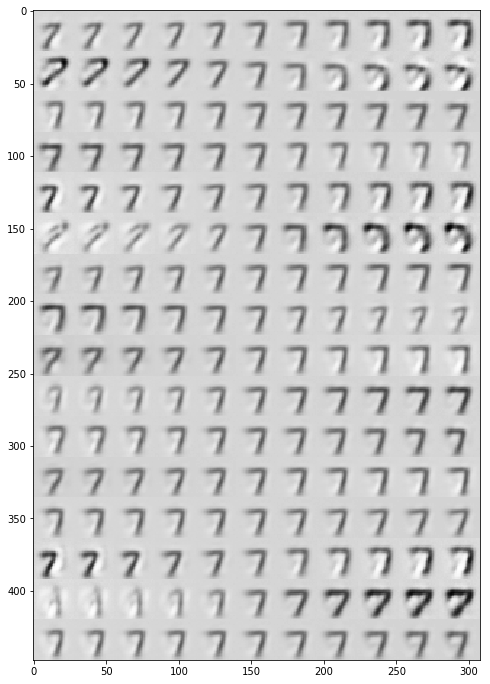

In [75]:
# Show the representation

#plt.figure(figsize=(12, 30))
plt.figure(figsize=(8, 20))
plt.imshow(latentImg, cmap='gray_r')
plt.show()